<a href="https://colab.research.google.com/github/ivychung/plant-ML/blob/anoushka-alexnet-implementation/AlexNet_10_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ========================================
# File Name : tomato_10_classes.ipynb
#
# Creation Date : Feburary 22, 2022
#
# Created By : Ivy Chung and Anoushka Gupta
# ========================================

"""Initializing required libraries"""

# so that we can mount google drive
from google.colab import drive

# numerical computation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gc # garbage collector to free objects on demand

# file manipulation
import zipfile
import os
import shutil

# load and show an image with Pillow
from PIL import Image

# load and display an image with Matplotlib
%matplotlib inline
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray

# sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold

# tensorflow tools
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# other
import cv2

from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Extract the dataset zip file
dataset_name = 'PlantVillage'
drive_dataset_address = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/dataset/'
working_dataset_address = os.path.join('/tmp/', dataset_name)

zip_ref = zipfile.ZipFile(drive_dataset_address + dataset_name + '.zip', 'r')
zip_ref.extractall('/tmp/') # Extracts the files into the appropriate folder
zip_ref.close()

In [4]:
# Removes the __MACOSX file that comes with zipping a file on Mac
try:
  shutil.rmtree('/tmp/__MACOSX')
except:
  pass

In [5]:
# Function to extract all sub- file/directory names
def read_filenames(dir_path, file_bool = True):
  if file_bool: # list all files in the folder
    return [f for f in os.listdir(dir_path) \
            if os.path.isfile(os.path.join(dir_path, f))]
  if not file_bool: # list all subfolders in the folder
    return [f for f in os.listdir(dir_path) \
            if os.path.isdir(os.path.join(dir_path, f))]


In [6]:
# getting classes
classes = read_filenames(working_dataset_address,file_bool = False)

# global variables to keep track of how many classes we have
CLASS_SIZE = len(classes)

classes

['Tomato_Bacterial_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Late_blight',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Leaf_Mold',
 'Tomato_healthy',
 'Tomato_Early_blight',
 'Tomato__Target_Spot']

In [7]:
# Collect all image names
img_names = [read_filenames(os.path.join(working_dataset_address, classes[i])) for i in range(CLASS_SIZE)]

# Row length should be the number of classes
print("Row Length", len(img_names))

# collect each column length
row_lengths = []
for i in range(CLASS_SIZE):
  row_lengths.append(len(img_names[i]))

print("Column length", row_lengths)

Row Length 10
Column length [2127, 1676, 1771, 3209, 1909, 373, 952, 1591, 1000, 1404]


Original image details
JPEG
(256, 256)
RGB

Image in pixel values
<class 'numpy.ndarray'>
(256, 256, 3) 



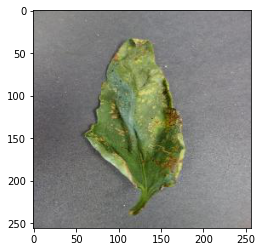


Tomato_Bacterial_spot


In [8]:
# checking image processing with one image
img_path = os.path.join(working_dataset_address, classes[0], img_names[0][1])

# reading the image
image = Image.open(img_path)

# summarize original image details
print("Original image details")
print(image.format)
print(image.size)
print(image.mode)

# convert image to numpy array of pixel values
data = asarray(image)

# summarize converted image details
print("\nImage in pixel values")
print(type(data))
print(data.shape, "\n")

plt.imshow(data)
plt.show()
print("\n" + classes[0])

In [9]:
# making a np array of the images in pixel values
x = []
y = []

for i in range(CLASS_SIZE):
  for j in range(len(img_names[i])):
    img_path = os.path.join(working_dataset_address, classes[i], img_names[i][j])
    try:
      img = Image.open(img_path)
      data = asarray(img) # convert image to numpy array
      x.append(data)
      y.append(classes[i])
    except:
      pass

image_count = len(x)
print("Total image count:", image_count)
x = np.asarray(x)
y = np.asarray(y)

Total image count: 16011


In [10]:
# convert our data vectors to the desired format
# Our x data vectors are four-dimensional, just as we wanted

# convert the labels be to int-encoded 
label_encoder = LabelEncoder()

# function to convert y data vectors int encoded class matrices
def convert_to_categorical(y_train, y_test, oneHot = True, makeArray = False):
  y_train = label_encoder.fit_transform(y_train)
  y_test = label_encoder.fit_transform(y_test)
  
  if oneHot:
    y_train = keras.utils.to_categorical(y_train, CLASS_SIZE)
    y_test = keras.utils.to_categorical(y_test, CLASS_SIZE)

  if makeArray:
    y_train = np.array([np.array([y]) for y in y_train])
    y_test = np.array([np.array([y]) for y in y_test])
  
  return y_train, y_test

In [11]:
# Now we need to split the data into a training and a validating dataset
x_train, x_test, y_train, y_test = train_test_split(x, y,
    test_size=0.2, shuffle = True, random_state = 8)

# convert the label formatting
y_train, y_test = convert_to_categorical(y_train, y_test, False, True)

In [12]:
print(type(y_train))
print(type(y_train[0]))
print(y_train[0].shape)
print(y_train[0])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1,)
[0]


In [13]:
# check our final shape
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (12808, 256, 256, 3)
x_test shape: (3203, 256, 256, 3)
y_train shape: (12808, 1)
y_test shape: (3203, 1)


In [14]:
# takes the train, test, and validation dataset partitions and returns a corresponding TensorFlow Dataset representation
train_ds=tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((x_test,y_test))

In [15]:
image_size = 256
# function to preprocess image
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(image_size,image_size))
    
    return image,label

In [16]:
# input pipeline
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)

Train size: 12808
Test size: 3203


In [17]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

In [18]:
AlexNet_model=keras.models.Sequential([
  keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(image_size,image_size,3)),
  keras.layers.BatchNormalization(),

  keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
  keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
  keras.layers.BatchNormalization(),

  keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
  keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
  keras.layers.BatchNormalization(),

  keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
  keras.layers.BatchNormalization(),

  keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
  keras.layers.BatchNormalization(),

  keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
  keras.layers.Flatten(),
  keras.layers.Dense(4096,activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(4096,activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(10,activation='softmax')  

])

In [19]:
AlexNet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.001),
    metrics=['accuracy']    
)
AlexNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [20]:
# use callback to find the optimal number of epochs to use
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [21]:
# validation accuracy here is test accuracy

history = AlexNet_model.fit(
    train_ds,
    epochs = 70,
    validation_data = test_ds,
    validation_freq = 1,
    callbacks =[earlystopping]
)

print('Test accuracy Score = ',np.max(history.history['val_accuracy']))

Epoch 1/70
400/400 [==============================] - 30s 47ms/step - loss: 1.6582 - accuracy: 0.5262 - val_loss: 1.0380 - val_accuracy: 0.6253
Epoch 2/70
400/400 [==============================] - 32s 61ms/step - loss: 0.8235 - accuracy: 0.7261 - val_loss: 0.4766 - val_accuracy: 0.8319
Epoch 3/70
400/400 [==============================] - 34s 66ms/step - loss: 0.6299 - accuracy: 0.7779 - val_loss: 0.3772 - val_accuracy: 0.8700
Epoch 4/70
400/400 [==============================] - 34s 66ms/step - loss: 0.5323 - accuracy: 0.8134 - val_loss: 0.3492 - val_accuracy: 0.8788
Epoch 5/70
400/400 [==============================] - 33s 64ms/step - loss: 0.4376 - accuracy: 0.8466 - val_loss: 0.2914 - val_accuracy: 0.9025
Epoch 6/70
400/400 [==============================] - 33s 65ms/step - loss: 0.3849 - accuracy: 0.8634 - val_loss: 0.2878 - val_accuracy: 0.8956
Epoch 7/70
400/400 [==============================] - 34s 66ms/step - loss: 0.3515 - accuracy: 0.8803 - val_loss: 0.2570 - val_accuracy:

In [22]:
AlexNet_model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

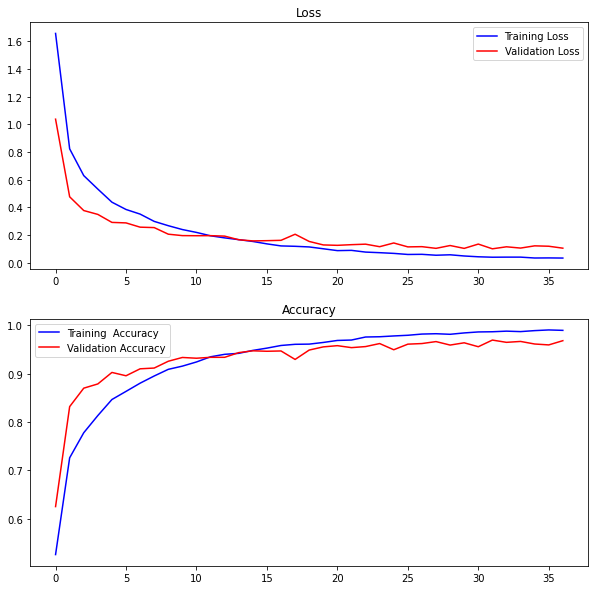

In [23]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(AlexNet_model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(AlexNet_model.history.history['val_loss'],color='r',label='Validation Loss')
ax[0].title.set_text('Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(AlexNet_model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(AlexNet_model.history.history['val_accuracy'],color='r',label='Validation Accuracy')
ax[1].title.set_text('Accuracy')

ax[0].legend()
ax[1].legend()


In [24]:
print('Accuracy Score = ',np.max(history.history['val_accuracy']))

Accuracy Score =  0.9693750143051147


In [25]:
# testing saving trained model 
base_save_path = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/Trained Models/'
save_path = base_save_path+'Tomato 10 Classes AlexNet/'
AlexNet_model.save(save_path)

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/Trained Models/Tomato 10 Classes AlexNet/assets


In [26]:
# # testing loading model
# model = keras.models.load_model(save_path)

In [27]:
# # checking image at index 3. The :4 is to add another dimension
# # to fit the 4-dimension requirement
# i = 1
# img = tf.image.resize(x_test[i:i+1],(64,64))
# y_pred = AlexNet_model.predict(img)[0]
# y_pred

In [28]:
# prediction = y_pred.argmax()
# actual = y_test[i].argmax()

# print('Prediction:', classes[prediction])
# print('Actual:', classes[actual])

In [29]:
# plt.imshow(x_test[3])
# plt.show()